In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import re
import ast

In [2]:
files = glob.glob('LinkageAnalysis/*.csv')
files

['LinkageAnalysis\\AfricanLinkageAnalysis.csv',
 'LinkageAnalysis\\AmericanLinkageAnalysis.csv',
 'LinkageAnalysis\\EastAsianLinkageAnalysis.csv',
 'LinkageAnalysis\\EuropeanLinkageAnalysis.csv',
 'LinkageAnalysis\\SouthAsianLinkageAnalysis.csv']

In [3]:
dfs = []
for file in files:
    population = re.search('[A-Za-z]+\.csv', file).group()
    population = re.sub('LinkageAnalysis\.csv', '', population)
    df = pd.read_csv(file)
    df['subpopulation'] = [population] * len(df)
    dfs.append(df)
df = pd.concat(dfs)
df

,CHR_A,BP_A,SNP_A,CHR_B,BP_B,SNP_B,R2,subpopulation
0,2,139063738,rs16841562,2,139064447,rs10928684,1.000000,African
1,4,93157863,rs7683744,4,93158357,rs1503211,0.995819,African
2,4,93146102,rs6844422,4,93154693,rs1503212,0.992077,African
3,18,3660801,rs9952159,18,3661485,rs8096356,0.989080,African
4,4,93130984,rs17264265,4,93157806,rs7661294,0.948709,African
...,...,...,...,...,...,...,...,...
152,4,92744627,rs954467,4,93073446,rs1511295,0.142572,SouthAsian
153,4,92744627,rs954467,4,93093005,rs12506519,0.142572,SouthAsian
154,4,92764254,rs2046015,4,93073446,rs1511295,0.142492,SouthAsian
155,4,92764254,rs2046015,4,93093005,rs12506519,0.142492,SouthAsian


In [4]:
snp_gene_df = pd.read_csv('Gene_SNP_ID_table.csv')
snp_gene_df

,Unnamed: 0,GENE,SNP
0,0,LINC02225,rs1844437
1,1,LINC02101,rs1844437
2,2,LINC01581,rs2388436
3,3,H3P40,rs2388436
4,4,AL391840.3,rs3747767
...,...,...,...
818,535,LINC01630,rs321849
819,536,LINC01630,rs321858
820,537,SIGLECL1,rs10410689
821,538,NaN,rs6132764


In [5]:
df = df[df.R2 >= 0.8][['SNP_A', 'SNP_B', 'subpopulation']]
df

,SNP_A,SNP_B,subpopulation
0,rs16841562,rs10928684,African
1,rs7683744,rs1503211,African
2,rs6844422,rs1503212,African
3,rs9952159,rs8096356,African
4,rs17264265,rs7661294,African
...,...,...,...
60,rs10021088,rs6844422,SouthAsian
61,rs10021088,rs1354296,SouthAsian
62,rs10021088,rs1503212,SouthAsian
63,rs6844422,rs1503211,SouthAsian


In [6]:
snp_dic = {}
for index, row in snp_gene_df.iterrows():
    snp = row['SNP']
    gene = row['GENE']
    if gene in snp_dic:
        snp_dic[gene].append(snp)
    else:
        snp_dic[gene] = [snp]
        

In [7]:
pathway_df = pd.read_csv('KEGG_Pathway_analysis/intersting_kegg_pathways.csv')
pathway_df
gene_set = set()
for gene_list in pathway_df.enriched_genes:
    gene_list = ast.literal_eval(gene_list)
    for gene in gene_list:
        gene_set.add(gene)

In [8]:
snp_set = set()
for gene in gene_set:
    snps = snp_dic[gene]
    for snp in snps:
        snp_set.add(snp)
snp_set

{nan,
 'rs10021088',
 'rs10491964',
 'rs10928684',
 'rs12506519',
 'rs1354296',
 'rs1495509',
 'rs1503211',
 'rs1511295',
 'rs16841562',
 'rs2514218',
 'rs2648727',
 'rs4286490',
 'rs4298967',
 'rs6838743',
 'rs7683744',
 'rs7686545'}

In [9]:
rows = []
for population in pd.unique(df.subpopulation):
    new_row = dict()
    count = 0
    pop_df = df[df.subpopulation == population]
    for snpA, snpB in zip(pop_df.SNP_A, pop_df.SNP_B):
        if snpA in snp_set and snpB in snp_set:
            count += 1
    frequency = count / len(pop_df)
    new_row['subpopulation'] = population
    new_row['linked_snp_frequency'] = frequency
    rows.append(new_row)
linked_snp_frequency_df = pd.DataFrame(rows)
linked_snp_frequency_df
            

,subpopulation,linked_snp_frequency
0,African,0.388889
1,American,0.278689
2,EastAsian,0.285714
3,European,0.234043
4,SouthAsian,0.261538


In [10]:
linked_snp_frequency_df['DALY'] = [97.5/100000, 120/100000, 45/100000, 67.5/100000, 60/100000]

C:\Users\nanel\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


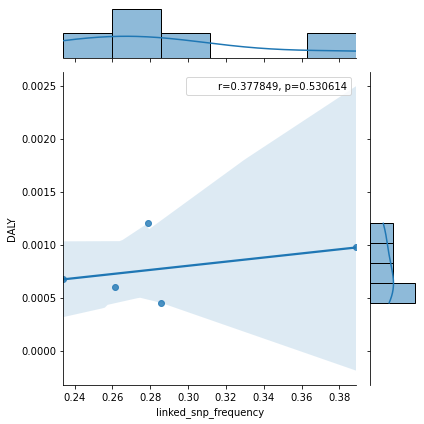

In [11]:
import scipy.stats as stats
j = sns.jointplot('linked_snp_frequency', 'DALY', data = linked_snp_frequency_df, kind = 'reg')
r,p = stats.pearsonr(linked_snp_frequency_df['linked_snp_frequency'], linked_snp_frequency_df['DALY'])
phantom, = j.ax_joint.plot([], [], linestyle="", alpha=0)
j.ax_joint.legend([phantom],['r={:f}, p={:f}'.format(r,p)])
plt.tight_layout()
plt.savefig('linkage_correlation.png')
plt.show()